# Preprocessing Striketime Code

 Translated to Python and Modified by: Om Guin (om.guin@gmail.com)

Designed for new style TAMU data (event-time files). NOT backward compatable but similar algorithm. Will need to update Preparams.params file to match new input style where there can be up to three data channels A,B,C.  The col values indicate which data column the data is stored in, where 0 means no data for that channel.
    datatype null null sampletime driftwinA driftwinB basethreshA basethreshB corrt dofit colA colB colC
Sabreen Update  d to store results differently than before.

 
Run this from the directory containing the data files
Point of this code is to find events and their amplitudes. Input parameters for this include a minimum threshold amplitude. Currently there is the thought of handling spikes in a detected non-zero  background. To run the same spike finding algoryhtm one needs to perform a "basethresh" filter where all data below basethresh (a.k.a. cut threeshold in bd_175) are set to zero. This facilitates bracketing events with zeros as would be the case for the "clean" single particle events BAS assumes. This type of application HAS NOT BEEN TESTED. At the very least, need to confirm that adding random noise background to a single particle burst signal leads to recovery of correct distribution.
To use code in this way will be iterative as stands. Try plotting the time stream to determine a basethresh value to place in the parameters.params file. Suggest perhaps 3 to 5 times rms of time stream. We can automate/hardcode this after some exploration. 
Output:
datastat = 0   if no data processed for that channel
datastat = 1   if processed w/o Gaussian fit to events (dofit=0)
datastat = complex structure if Gaussian fits done (dofit=1)
handles.base = 0    if no data for the channel
handles  .base .strike .strikeamp .d    returned in structure for processed channel


In [117]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate, correlation_lags, medfilt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.stats import linregress
from datetime import datetime
from ipyfilechooser import FileChooser
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# Part 1 - Functions

### Rolling window filter to remove baseline wander but retain overall mean of timestream


In [118]:
def basedrift_data(I, driftwin, channel):
    """
    % Removes a smoothed baseline from timestream but retains overall mean of
    % timestream; Use a 50 sample median filter (slow and memory intensive but largely insensitive to spikes) 
    % followed by a 12000 sample averaging filter on that result (fast and
    % roughly 6 second time constant with nominal 0.5 ms sampling
    """

    medianI = np.median(I)
    qq = I - medianI #removes median to roughly center baseline on zero
    ksize = np.fix(driftwin*50)
    if ksize % 2 == 0:  # Ensure odd
        ksize += 1
    MF = medfilt(qq, kernel_size=ksize) #sets window size and filters
    basedrift = MF+medianI #restores original amplitude
    basedrift = gaussian_filter1d(basedrift, sigma = 12000/6)

    cI = I - basedrift
    cI += medianI
    cI[cI < 0] = 0

    plt.figure()
    plt.plot(I, 'b', label='Original')
    plt.plot(basedrift, 'r', label='Baseline Drift')
    plt.xlim([0, 10000])
    plt.ylim([0, medianI * 5])
    plt.title(f'Original data with drift overplotted : {channel}')
    plt.legend()
    plt.show()
    
    return cI, basedrift

### Offset removal
In bd_175.m this is also called "Cut threshold". This routine can be used to subtract a background before finding spikes and spike amps. This subtracts a smoothed drifting function from the raw data and sets any values below zero to zero. The idea is to remove an unresolved, ubiquitous, luminous background that is adding to the event amplitudes.


In [119]:
def basethresh_data(I, basethresh, channel):
    """
    % Used same median filter as used in Basedrift to find a baseline but is then removed. Zeroes out any data 
    % below zero value in each channel. 
    % Use a 50 sample median filter (slow and memory intensive but largely insensitive to spikes) 
    % followed by a 12000 sample averaging filter on that result (fast and
    % roughly 6 second time constant with nominal 0.5 ms sampling
    """
    medianI = np.median(I)
    qq = I - medianI #Removes median to roughly center baseline on zero
    ksize = np.fix(basethresh*50).astype(int)
    if ksize%2==0:
        ksize+=1
    
    MF = medfilt(qq, kernel_size=ksize) #sets window size and filters
    baseoffset = MF+medianI #restores original amplitude
    baseoffset = gaussian_filter1d(baseoffset, sigma = 12000/6) #SLIGHTLY DIFFERENT FROM MATLAB VERSION
 
    cI = I - baseoffset #Remove drift but now there are negative values
    cI[cI < 0] = 0 #zero any negative values

    #Overplot data and baseline in zoomed in function
    plt.figure()
    plt.plot(I, 'b', label='Original')
    plt.plot(baseoffset, 'r', label='Baseline Offset')
    plt.xlim([0, 10000])
    plt.ylim([0, max(medianI * 5, 10)]) #Handles cases with zero median value
    plt.title(f'Original presubtracted data with filtered baseline offset to be SUBTRACTED : {channel}')
    plt.legend()
    plt.show()

    return cI, baseoffset

### Save processed results to .npz -- example unpacking in last cell

In [120]:
def save_preprocessed(pre_path, pre_filename, datastatA, datastatB, datastatC, handlesA, handlesB, handlesC, peaklocA, peaklocB, peaklocC, readme_pre, versionnum): 
    #Get information about this data run and create a director for this data store
    filebase, tstr = Information(versionnum)
    newdir = os.path.join(pre_path, f"{filebase}_{tstr}")
    os.makedirs(newdir, exist_ok=True)

    save_file_path = os.path.join(newdir, f"{filebase}{pre_filename}{tstr}.npz")
    np.savez_compressed(
        save_file_path,
        datastatA=datastatA,
        datastatB=datastatB,
        datastatC=datastatC,
        filebase=filebase,
        handlesA=handlesA,
        handlesB=handlesB,
        handlesC=handlesC,
        newdir=newdir,
        peaklocA=peaklocA,
        peaklocB=peaklocB,
        peaklocC=peaklocC,
        prefilenamesave=save_file_path,
        pre_filename=pre_filename,
        pre_path=pre_path,
        readmePRE=readme_pre,
        tstr=tstr,
        versionnum=versionnum
    )
    print(f"Preprocessed data saved to: {save_file_path}")
    return save_file_path

### Find burst location times and amplitudes (preprocess)

In [141]:
def burst_data(d, tbin, corrt, dofit, channel, handles, species_label_stream=None):
    """
    %This is original 2013 preprocessing code used in MegaMan_V1.m and bd_175
    %Some of the commented code is left to show comparison to what was - if
    %commented it was not doing anything even in old code
    %Channel data are mapped to appropriate old variables like handles
    %Input variable channel is string to label channel being processed
    %handles.medwin=5;    Not used in bd_175 either
    """
    handles['d'] = np.zeros((2, len(d)))
    handles['d'][0, :] = np.arange(len(d)) * tbin #make time vector in seconds
    handles['d'][1, :] = d #time data filtered by drift and basethresh is read in
    #handles['base'] =d     Original time data unfiltered is read in

    print(f"***** Processing channel : {channel}")

    #Show original data
    plt.figure()
    plt.plot(handles['d'][0, :], handles['base'], label='Original') #show original time stream data
    plt.plot(handles['d'][0, :], handles['d'][1, :], '.r', label = "Optionally filtered")
    plt.title(f"Optionally drift/baseline filtered timestream and original {channel}", fontsize=12)
    plt.xlabel("Total Concatenated Time (seconds)")
    plt.ylabel("Photon counts per time bin")
    plt.legend(loc = "upper left")
    plt.show()

    """
    Consider using a threshold level to define when burst boundary happens
    rather than always using zero

    Set an amplitude threshold for base aof spike to 0, mean, median, rms, or
    dynamic range (1/100) of large spike
    """
    #Determine upper range of spike activity ; 30 is a heuristic parameter
    sortbase = np.sort(handles['base'])
    UB = np.median(sortbase[-30:])

    #Determine lower bound (threshold) of trustable spike activity
    #Default to mean for most cases
    handles['spthreshtype'] = 'mean' # @param ["mean", "zero", "median", "rms", "dynamicrange"]
    dynrange = 100

    if handles['spthreshtype'] == 'zero':
        spikethresh = 0
        print("Chosen spike finding threshold is zero")
    elif handles['spthreshtype'] == 'mean':
        spikethresh = 2* handles['mean']
        print("Chosen spike finding threshold setting is the 2*mean of 5-sigma filtered data set")
    elif handles['spthrestype'] == 'median':
        spikethresh = 2 * handles['median']
        print("Chosen spike finding threshold setting is the 2*median of 5-sigma filtered data set")
    elif handles['spthrestype'] == 'rms':
        spikethresh = 2 * handles['rms']
        print("Chosen spike finding threshold setting is the 2*rms of 5-sigma filtered data set")
    elif handles['spthrestype'] == 'dynamicrange':
        #Estimate upper bound on events in a channel
        spikethresh = round(UB/dynrange)
        print(f"Applying a 1/100 dynamic range threshold : {spikethresh}")
        print("Chosen spike finding threshold setting is UB/100 of dataset")

    #Bound lower threshold has some constraints
    if spikethresh < round(UB / dynrange): #the dynamic range is minimum possible
        spikethresh = round(UB / dynrange)
        print('**** OVERRIDE: Restricted to Upper Bound / 100 as lower limit ****')
    if spikethresh < 10: # set 10 as a lower limit in all cases due to shot noise
        spikethresh = 10
        print('**** OVERRIDE: Restricted to 10 cnts as lower limit - arbitrary Poisson noise limit ****')

    #Store parameters in structure for later use
    handles['spthresh'] = spikethresh
    handles['UB'] = UB

    strike = np.array(d) #data imported to function (not baseline)

    #Set a lower bound for spike finding below the threshold as a way of estimating the subthreshold
    #activity later
    print(f"Setting lower spike acceptance threshold to: {spikethresh}")
    print(f"Retaining subthreshold spikes between {spikethresh/2} and {spikethresh} in Handles structure")
    strike[strike < spikethresh / 2] = 0 #Set lower amplitude to find the edge of spikes

    #Guarantee zeroed end points
    strike[0:2] = 0
    strike[-2:] = 0

    while True:
        t = np.max(np.where(strike == np.max(strike))[0]) #This could be 2nd pnt, 2nd ot last pnt or in the middle of data
        strike[t] = -1 #tip of peak in single event set to -1
        i = 1
        rightend = leftend = True
        while rightend or leftend:
            if rightend:
                ti_index = max(min(t + i, len(strike) - 1), 1) #because nonzero index needed
                if abs(strike[ti_index]) > 0: #see comment above about threshold
                    strike[ti_index] = 0
                else:
                    rightend = False
            if leftend:
                ti_index = max(min(t - i, len(strike) - 1), 1)
                if abs(strike[ti_index]) > 0: #See comment above about threshold
                    strike[ti_index] = 0
                else:
                    leftend = False
            i += 1
        if np.max(strike) <= 0:
            break

    handles['strike'] = -strike
    handles['strikeamp'] = -strike * handles['d'][1, :]

    # Plot spike amplitudes
    plt.figure()
    plt.plot(handles['d'][0, :], handles['strikeamp'], 'r.', label='Located peaks')
    plt.plot(handles['d'][0, :], handles['d'][1, :], 'b')
    plt.axhline(y=UB, color='k', linestyle='-')
    plt.title(f'Threshold & Upperbound with located peaks {channel}', fontsize=12)
    plt.xlabel('Total Concatenated Time (seconds)')
    plt.ylabel('Photon counts per time bin')
    plt.legend()
    plt.show()

    # Store some of tne spike data below the threshold for later noise and 
    # signle event prob analysis; zero these data in main propagated data
    # variables
    submask = handles['strikeamp'] < spikethresh
    handles['subthreshstrike'] = handles['strike'] * submask
    handles['subthreshstrikeamp'] = handles['strikeamp'] * submask
    strike_mask = handles['strikeamp'] > spikethresh
    handles['strike'] *= strike_mask
    handles['strikeamp'] *= strike_mask


    # Check interspike timing statistics and remove events too closely spaced
    print("Checking interspike timing distribution and removing events closer than corrt")
    ISI_check(handles,tbin,corrt)
        
    #Consider peaks away from very edge of data set; 15 bin buffer is
    #sized for later Gaussian model fit to events
    peakloc = np.where(handles['strikeamp'] > 0)[0]
    peakloc = peakloc[(peakloc > 15) & (peakloc < len(handles['strikeamp']) - 15)]
    npeaks = len(peakloc)
    if species_label_stream is not None:
        species_label_stream = species_label_stream.ravel(order='F')
    total_skipped = 0
    #Do fit of Gaussian model to each event if dofit flag set in parameter
    if dofit: #Hook to turn off Gausian fitting - remove datastat=1 too
        params = {'mean': [], 'sig': [], 'A': []}
        handles['amplitude'], handles['width'], handles['area'], handles['rise'], handles['fall'], handles['skew'], handles['kurt'], handles['species'] = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
        handles['burst_windows'] = []
        burst_radius = 10
        for i in range(npeaks):
            #start with general spike zone
            center = peakloc[i]
            #fitme = handles['d'][1, center - 10:center + 11]
            #dzone = int(2 * np.sum(fitme) / np.max(fitme)) #refine zone assuming Gaussian peak
            #x = np.arange(center - dzone, center + dzone + 1)
            #fitme = handles['d'][1, center - dzone:center + dzone + 1]
            #A, mu, sigma = fitgauss(fitme, x, np.max(fitme), center, 3)
            #params['mean'].append(mu)
            #params['sig'].append(sigma)
            #params['A'].append(A / np.sqrt(2 * np.pi * sigma ** 2)) #A is now amplitude

            #other burst parameters
            window_start = center - burst_radius
            window_end = center + burst_radius+1
            if window_start < 0 or window_end > handles['d'].shape[1]:
                total_skipped+=1
                continue
            burst_window = handles['d'][1,:][window_start:window_end]
            if np.sum(burst_window) == 0:
                total_skipped+=1
                continue
            #width
            #half_max = np.max(burst_window) / 2
            #above_half = np.where(burst_window >= half_max)[0]
            #width = (above_half[-1] - above_half[0]) * tbin if len(above_half) >= 2 else tbin
            #area
            #area = np.sum(burst_window)
            #rise/fall
            #peak_pos = np.argmax(burst_window)
            #left = burst_window[:peak_pos]
            #right = burst_window[peak_pos+1:]
            #rise = np.argmax(left[::-1] < 0.1 * np.max(burst_window)) if len(left) > 0 else 0
            #fall = np.argmax(right < 0.1 * np.max(burst_window)) if len(right) > 0 else 0
            #rise_time = rise * tbin
            #fall_time = fall * tbin
            #skew & kurtosis
            #burst_skew = skew(burst_window)
            #burst_kurt = kurtosis(burst_window)
            
            #species
            if species_label_stream is not None:
                burst_labels = species_label_stream[window_start : window_end]
                burst_labels = burst_labels[burst_labels != -1]
                species = np.bincount(burst_labels).argmax() if len(burst_labels) > 0 else -1
                if(species==-1):
                    total_skipped+=1
                    continue   
                handles['species'] = np.append(handles['species'], species)
            handles['burst_windows'].append(burst_window)
            
            handles['amplitude'] = np.append(handles['amplitude'], handles['strikeamp'][center])
            #handles['width'] = np.append(handles['width'], width)
            #handles['area'] = np.append(handles['area'], area)
            #handles['rise'] = np.append(handles['rise'], rise_time)
            #handles['fall'] = np.append(handles['fall'], fall_time)
            #handles['skew'] = np.append(handles['skew'], burst_skew)
            #handles['kurt'] = np.append(handles['kurt'], burst_kurt)




        #q = [(0 < sig < 10 and 0 < A < 2 * np.max(handles['strikeamp'])) for sig, A in zip(params['sig'], params['A'])]
        #datastat = {
        #    'mean': [params['mean'][i] for i in range(len(q)) if q[i]],
        #    'sig': [params['sig'][i] for i in range(len(q)) if q[i]],
        #    'A': [params['A'][i] for i in range(len(q)) if q[i]]
        #}
        datastat = {}
    else:
        datastat = 1
    print(f"Total Skipped: {total_skipped}")

    return datastat, handles, peakloc

### Check intervals between events (ISI)

In [122]:
def ISI_check(handles, tbin, corrt):
    """
    % Uses events locations in peakloc and timestream stored in handles structure
    % to generate interspike interval plots compared to simple single-rate
    % poisson model. The sampling time tbin and the correlation time (~width of a
    % burst) corrt are used to exclude events that are too close in time.
    """
    nsamples = len(handles['strikeamp'].flatten()) #number of sample bins in concatenated data
    nhistbins = 100 #consider sampletime*nhistbins seconds of event spacing (typically 100ms)
    #Check interspike interval using generated time stream and a single
    #population model prediction based on random times and same avg rate
    
    striketimesm = np.sort(np.random.randint(1, nsamples, int(np.sum(handles['strike'])))) #chronological order of event bins
    peakshm = np.roll(striketimesm, 1)
    peakdiffm = striketimesm - peakshm #This spacing (ISI) gives statistical measure of

    #For reference, model of fsingle population distribution with same avg event rate
    #If multiple species, events shoud still be uncorrelated like 1 species
    #of higher rate
    xoutm = np.arange(1, nhistbins + 1)
    nm, _ = np.histogram(peakdiffm[1:-1], bins=xoutm) #hist of random samples for control
    plt.figure()
    plt.semilogy(xoutm[:-1] * tbin, nm, '-o')
    rate = len(striketimesm) / (tbin * nsamples)
    subtitle = f"Random event model w/ single event rate: {rate:.4f} events/sec"
    plt.title(f"Random Interspike Interval Dist Compared to Data\n{subtitle}")
    plt.xlabel('Time between events')
    plt.ylabel('Number of events')

    # Do again with real data shifted for comparison; should yield same powerlaw
    #slope; Overplot distributions
    qq = handles['strikeamp'].flatten() > 0
    striketimesd = np.arange(1, nsamples + 1)[qq] #need transpose to switch index order; indices where strikes occured
    rtd = np.sort(striketimesd)
    peakshd = np.roll(rtd, 1)
    peakdiffd = rtd - peakshd
    xoutd = np.arange(1, nhistbins + 1)
    nd, _ = np.histogram(peakdiffd[1:-1], bins=xoutd) #hist of random samples for control
    plt.semilogy(xoutd[:-1] * tbin, nd, '-ro')
    plt.legend(['Noiseless Model', 'Simulated Data'], loc='upper right')

    """
    %Find real data interspike intervals that don't violate correlation time
    %parameter corrt; keep first event of two that are too close; arbitrary
    %Would be better to keep larger amplitude event
    """
    dontkeep = np.abs(peakdiffd) < round(corrt / tbin) #logical indexing
    rr = rtd[dontkeep]
    handles['strikeamp'][rr - 1] = 0 #zero timing violation amplitude
    handles['strike'][rr - 1] = 0 #zero the strike flag as well

    #Now show with sub correlation time events removed
    print('-----------------------------------------')
    ntotevents = int(np.sum(handles['strike']))
    print(f"Removing {len(rr)} intertime violation events from {ntotevents} total events")
    qq = handles['strikeamp'].flatten() > 0
    striketimesd = np.arange(1, nsamples + 1)[qq] #need transpose to switch index order; indices where strikes occured
    rtd = np.sort(striketimesd)
    peakshd = np.roll(rtd, 1)
    peakdiffd = rtd - peakshd
    nd, _ = np.histogram(peakdiffd[1:-1], bins=xoutd) #hist of random samples for control
    plt.semilogy(xoutd[:-1] * tbin, nd, '-go')

    # Fit exponential model to distribution
    def exp_model(x, a, b):
        return a * np.exp(b * -1 * x)

    xdata = xoutd[:-1] * tbin
    ydata = nd
    popt, _ = curve_fit(exp_model, xdata, ydata, p0=[1, 1])
    plt.semilogy(xdata, exp_model(xdata, *popt))
    plt.legend(['random control', 'Input data', 'Remove timing violations'], loc='upper right')
    plt.show()

### Python equivalent of fitgauss() (MATLAB)

In [123]:
def fitgauss(fitme, x, max_fitme, peakloc, initial_sigma):
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
    # Initial guesses
    A0 = max_fitme
    mu0 = peakloc
    sigma0 = initial_sigma
    
    try:
        popt, pcov = curve_fit(gaussian, x, fitme, p0=[A0, mu0, sigma0])
        A, mu, sigma = popt
    except:
        A, mu, sigma = max_fitme, peakloc, initial_sigma
    
    return A, mu, sigma

### Outputs code version information

In [124]:
def Information(versionnum):
    #Display version and hold introductory information
    prepfile = f"Pre_{versionnum}"
    tstr = datetime.now().strftime("%d%b%y-%H%M%S")
    print(f"version number: {versionnum}")
    return prepfile, tstr

# Part 2

### Initialize

In [125]:
versionnum = "v1p1"
print("FOR TIME STAMP DATA FILES ONLY. Version information and details of modeling at bottom of mlx code ' ...' below the Information function")

FOR TIME STAMP DATA FILES ONLY. Version information and details of modeling at bottom of mlx code ' ...' below the Information function


### Choose subdirectory to process

In [126]:
fc = FileChooser('./')  # or use an absolute path if needed
fc.title = "<b>Select preprocessing parameter file</b>"
fc.filter_pattern = ['*.par']  # Only show .par files
display(fc)

FileChooser(path='C:\Users\omgui\Desktop\BASUS', filename='', title='<b>Select preprocessing parameter file</b…

In [127]:
PrePathName, PreFileName = os.path.split(fc.selected)
print(f"Using preprocessing parameter file: {PrePathName}{PreFileName}")

Using preprocessing parameter file: C:\Users\omgui\Desktop\BASUS\sim_data\TentSim_v1p9p3_18Jun25-09110818Jun25-091108-preparams.par


### Read parameter file


In [128]:
#The parameter file is assumed in same directory as data
#Parameter file should have 5 header lines at top 

paramfile = os.path.join(PrePathName, PreFileName)
#parse header for info
with open(paramfile, "r") as f:
    lines = f.readlines()
lines = [line for line in lines if line!="\n"]
readmePRE = {}
textdata = lines[0:len(lines)-1]
textdata[len(textdata)-1] = textdata[len(textdata)-1].split()
colheaders = textdata[-1]
data = [float(x) for x in lines[-1].split()]
readmePRE["data"] = data
readmePRE["textdata"] = textdata
readmePRE["colheaders"] = colheaders

preproparams = readmePRE["data"]
catfilenames = readmePRE["textdata"][5:len(readmePRE["textdata"])-1]
colheader = readmePRE["colheaders"]

#parameters: datatype sampletime driftwinA driftwinB basethreshA basethreshB corrt dofit colA colB colC
#some of these are obsolete. Datatype is used in case there is an update to
#formatting. Default is 1 for current TAMU format. Note, data files
#typically have txt header with words (say about first 13 lines).
datatype = readmePRE["data"][0] #Flag for possible changes in data formatting
Tottime = readmePRE["data"][1] #Total recording time
MTclock = readmePRE["data"][2] #TAMU photon counting board clock
tbin = readmePRE["data"][3] #Binning zine in seconds to form time series
driftwinA = readmePRE["data"][4] #integer bin factor multiplied by 2000
driftwinB = readmePRE["data"][5] #Slow drift removal
driftwinC = readmePRE["data"][6]
basethreshA = readmePRE["data"][7] #Low amplitude spike hash removal (integer cnts)
basethreshB = readmePRE["data"][8] #Does change amplitude of remaining data
basethreshC = readmePRE["data"][9]
corrt = readmePRE["data"][10] #Minimal time acceptable between events
dofit = readmePRE["data"][11] #Flag for Gaussian fit to events (usually 0)
colA = int(readmePRE["data"][12]) #Column number where A data located; 0 if no data
colB = int(readmePRE["data"][13]) #Column number where B data located; 0 if no data
colC = int(readmePRE["data"][14]) #Column number where C data located; 0 if no data

numcatfiles = len(catfilenames) #photon counts in time bins

I_A = [0]
I_B = [0]
I_C = [0]

#Set up time series using tbin and total time
print(f"Estimated number of samples per file at MT clock rate: {Tottime / MTclock}")
print(f"Estimated timestream dimension per file after requested binning time: {Tottime / tbin}")

#Determine edges of time bins for photon count per bin histogram to follow
Nafterbin = round(Tottime / tbin)
tedge = np.arange(0, Nafterbin + 1) * tbin


Estimated number of samples per file at MT clock rate: 121506682867.55771
Estimated timestream dimension per file after requested binning time: 20000.0


##### Concatenate data files into 3 color channel vectors

Concatenating files using single baseline offset defined in params file
Confirm mean and rms of all files similar!!
Number of NaN containing rows removed: 0
Add a data file for A Channel
Add a data file for B Channel
Number of NaN containing rows removed: 0
Add a data file for A Channel
Add a data file for B Channel
Number of NaN containing rows removed: 0
Add a data file for A Channel
Add a data file for B Channel
Number of NaN containing rows removed: 0
Add a data file for A Channel
Add a data file for B Channel
Number of NaN containing rows removed: 0
Add a data file for A Channel
Add a data file for B Channel
Number of NaN containing rows removed: 0
Add a data file for A Channel
Add a data file for B Channel
No C Channel data specified


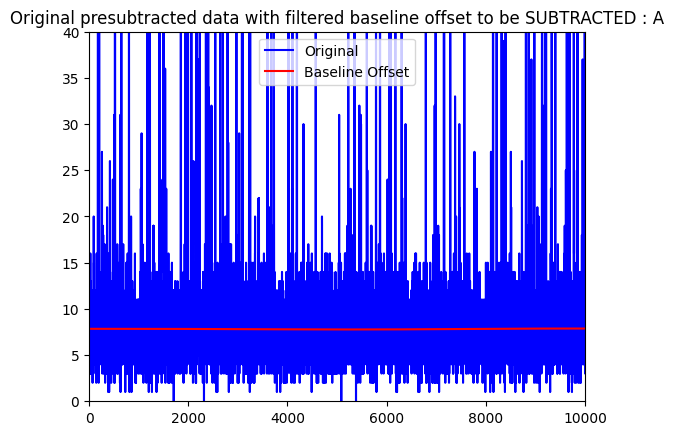

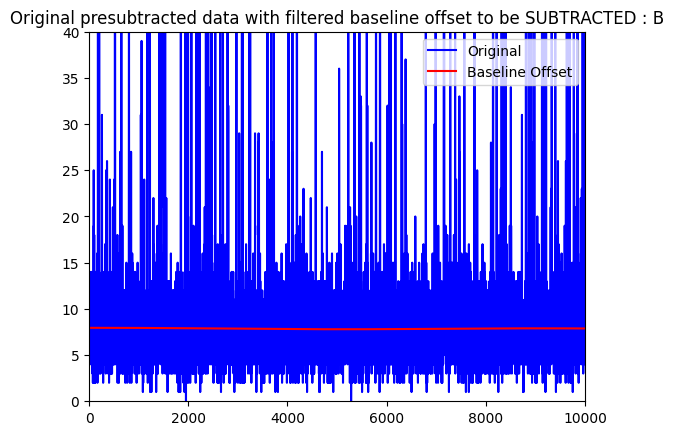

In [129]:
#This code block will take VERY long if using large amounts of data (generally from simulation)... Consider commenting plt.clf(), plt.hist(..), plt.pause(1) in each of the channel conditionals
print('Concatenating files using single baseline offset defined in params file')
print('Confirm mean and rms of all files similar!!')


for i in range(numcatfiles):
    filename = os.path.join(PrePathName, catfilenames[i].strip("\n"))

    with open(filename, "r") as f:
        lines = f.readlines()
    data_start_index = None
    for i, line in enumerate(lines):
        if "***end header***" in line:
            data_start_index = i + 2
            break
    if data_start_index is None:
        raise ValueError("Bad file... couldn't find header")
    
    temp = pd.read_csv(filename, delimiter='\t', skiprows=data_start_index+1, header=None) #Tab delimited
    #Handle possible NaN values - should be very infrequent
    ss = temp.mean(axis = 1) #use to find rows with NaN's then drop those rows
    allnans = np.where(~np.isfinite(ss))[0]
    numnans = len(allnans)
    print(f"Number of NaN containing rows removed: {numnans}")
    temp = temp.drop(index = allnans)

    #Form up to 3 color channels
    if colA != 0:
        print("Add a data file for A Channel")
        tempA = temp.iloc[:, colA - 1].to_numpy() * MTclock * 2 #Arrival times in seconds for one file
        #factor of 2 is a feature of the BH board
        tempA = tempA[tempA != 0] #Remove 0's that pad the data columns
        #Apply binning set by valiable tbin=readmePRE["data"][3]
        histA, _ = np.histogram(tempA, bins=tedge)
        I_A.extend(histA.tolist())
        #plt.clf() #Clear current figure
        #plt.hist(tempA, bins=tedge)
        #plt.pause(1)
    if colB != 0:
        print("Add a data file for B Channel")
        tempB = temp.iloc[:, colB - 1].to_numpy() * MTclock * 2 #Arrival times in seconds for one file
        #factor of 2 is a feature of the BH board
        tempB = tempB[tempB != 0] #Remove 0's that pad the data columns
        #Apply binning set by valiable tbin=readmePRE["data"][3]
        histB, _ = np.histogram(tempB, bins=tedge)
        I_B.extend(histB.tolist())
        #plt.clf() #Clear current figure
        #plt.hist(tempB, bins=tedge)
        #plt.pause(1)
    if colC != 0:
        print("Add a data file for C Channel")
        tempC = temp.iloc[:, colC - 1].to_numpy() * MTclock * 2 #Arrival times in seconds for one file
        #factor of 2 is a feature of the BH board
        tempC = tempC[tempC != 0] #Remove 0's that pad the data columns
        #Apply binning set by valiable tbin=readmePRE["data"][3]
        histC, _ = np.histogram(tempC, bins=tedge)
        I_C.extend(histC.tolist())
        #plt.clf() #Clear current figure
        #plt.hist(tempA, bins=tedge)
        #plt.pause(1)

#Remove first null data point and initialize original timestream output and
#find spike-free rms, mean and median for possible offset correction in BAS code
handlesA = {}

if colA!=0:
    I_A = I_A[1:]
    handlesA['base'] = I_A
    rms1 = np.std(I_A, ddof=1)
    qrms1 = I_A < 5 * rms1 # Data that isn't part of major spike activity
    handlesA["rms"] = np.std(np.array(I_A)[qrms1], ddof=1)
    handlesA["median"] = np.median(np.array(I_A)[qrms1])
    handlesA["mean"] = np.mean(np.array(I_A)[qrms1])
else:
    print("No A Channel data specified")
    handlesA['base'] = 0
    datastatA = 0
    peaklocA = 0

handlesB = {}
if colB!=0:
    I_B = I_B[1:]
    handlesB['base'] = I_B
    rms1 = np.std(I_B, ddof=1)
    qrms1 = I_B < 5 * rms1 # Data that isn't part of major spike activity
    handlesB["rms"] = np.std(np.array(I_B)[qrms1], ddof=1)
    handlesB["median"] = np.median(np.array(I_B)[qrms1])
    handlesB["mean"] = np.mean(np.array(I_B)[qrms1])
else:
    print("No B Channel data specified")
    handlesB['base'] = 0
    datastatB = 0
    peaklocB = 0

handlesC = {}
if colC!=0:
    I_C = I_C[1:]
    handlesC['base'] = I_C
    rms1 = np.std(I_C, ddof=1)
    qrms1 = I_C < 5 * rms1 # Data that isn't part of major spike activity
    handlesC["rms"] = np.std(np.array(I_C)[qrms1], ddof=1)
    handlesC["median"] = np.median(np.array(I_C)[qrms1])
    handlesC["mean"] = np.mean(np.array(I_C)[qrms1])
else:
    print("No C Channel data specified")
    handlesC['base'] = 0
    datastatC = 0
    peaklocC = 0

#Apply slow drift correction to baseline (paramsfile parameter 5&6)
if driftwinA != 0 and colA != 0:
    I_A, basedrift = basedrift_data(I_A, driftwinA, "A")
    handlesA['basedriftA'] = basedrift
if driftwinB != 0 and colB != 0:
    I_B, basedrift = basedrift_data(I_B, driftwinB, "B")
    handlesB['basedriftB'] = basedrift
if driftwinC != 0 and colC != 0:
    I_C, basedrift = basedrift_data(I_C, driftwinC, 'C')
    handlesC['basedriftC'] = basedrift

#Apply baseline threshold filter (paramsfile parameters 7&8) to subtract offset
if basethreshA != 0 and colA != 0:
    I_A, baseoffset = basethresh_data(I_A, basethreshA, 'A')
    handlesA['baseoffsetA'] = baseoffset
if basethreshB != 0 and colB != 0:
    I_B, baseoffset = basethresh_data(I_B, basethreshB, 'B')
    handlesB['baseoffsetB'] = baseoffset
if basethreshC != 0 and colC != 0:
    I_C, baseoffset = basethresh_data(I_C, basethreshC, 'C')
    handlesC['baseoffsetC'] = baseoffset

### Determine location and amplitudes of spikes in concatenated dataset

In [142]:
specieslabels = np.load(os.path.join(PrePathName, "specieslabels.npy"))
specieslabels.shape

(20000, 6)

***** Processing channel : A


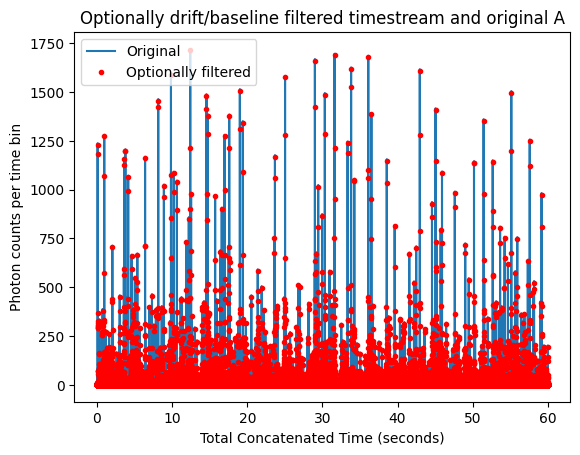

Chosen spike finding threshold setting is the 2*mean of 5-sigma filtered data set
Setting lower spike acceptance threshold to: 19.84880496611348
Retaining subthreshold spikes between 9.92440248305674 and 19.84880496611348 in Handles structure


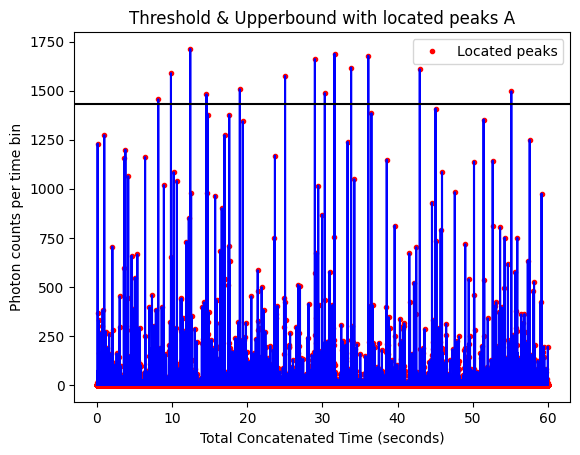

Checking interspike timing distribution and removing events closer than corrt
-----------------------------------------
Removing 5 intertime violation events from 1011 total events


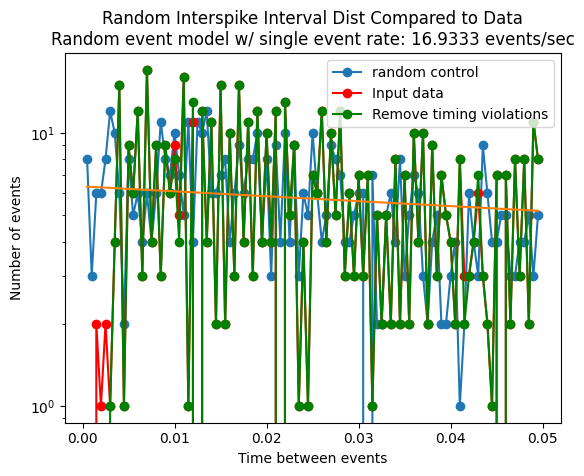

Total Skipped: 149
***** Processing channel : B


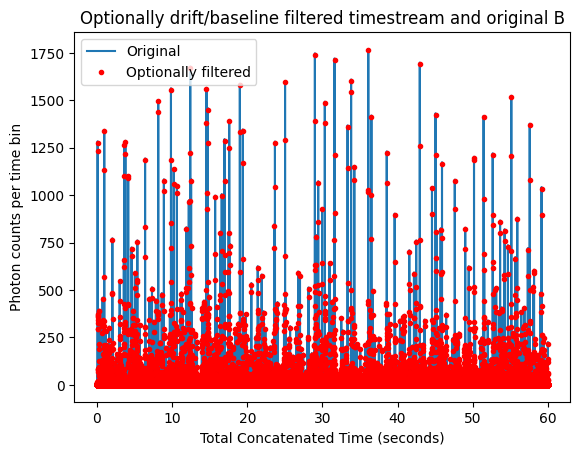

Chosen spike finding threshold setting is the 2*mean of 5-sigma filtered data set
Setting lower spike acceptance threshold to: 20.647424615745628
Retaining subthreshold spikes between 10.323712307872814 and 20.647424615745628 in Handles structure


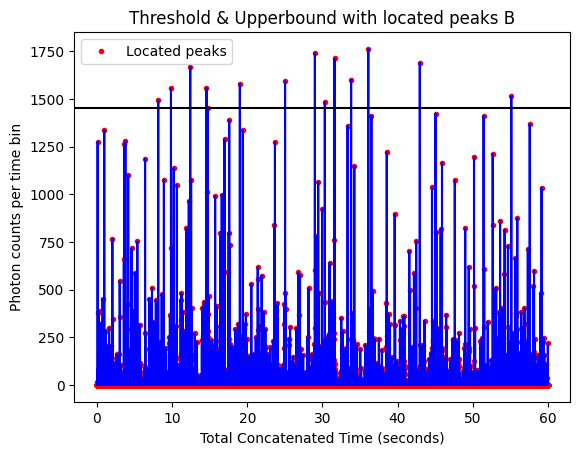

Checking interspike timing distribution and removing events closer than corrt
-----------------------------------------
Removing 2 intertime violation events from 1119 total events


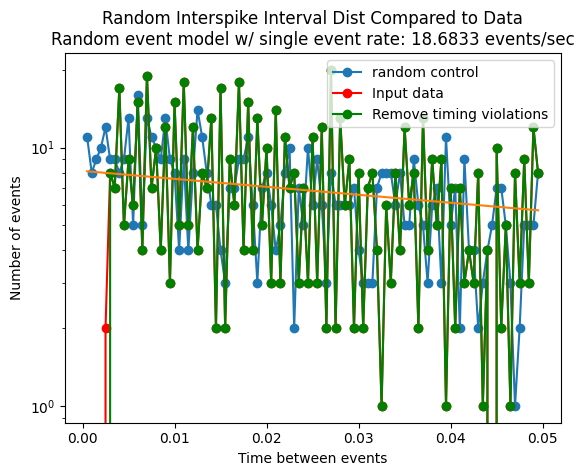

Total Skipped: 0


In [143]:
if colA != 0:
    datastatA, handlesA, peaklocA = burst_data(I_A, tbin, corrt, dofit, 'A', handlesA, species_label_stream = specieslabels)
if colB != 0:
    datastatB, handlesB, peaklocB = burst_data(I_B, tbin, corrt, dofit, 'B', handlesB)
if colC != 0:
    datastatC, handlesC, peaklocC = burst_data(I_C, tbin, corrt, dofit, 'C', handlesC)

### Check rate of strikes and single particle limit
##### Use a few stats to determine if single particle limit holds for this dataset

In [144]:
do_strikestats = False

if do_strikestats:
    #Determine some statistics about detecting spikes
    if colA != 0:
        print(">>>>>>>Channel A")
        numbins = len(handlesA["strike"])
        numspA = np.sum(handlesA["strike"])
        print(f"Number events above A threshold: {numspA}")
        #If random, prob of spikes in singnle bin and multiple adjacent bins
        p0bin1A = (numbins - numspA) / numbins
        p1bin1A = numspA/numbins
        print(f"Prob of 0 event in a bin: {p0bin1A}")
        print(f"Prob of 1 event in a bin: {p1bin1A}")
        print(f"Prob of 2 events in a bin based on P(n=1)^2: {p1bin1A**2}")
        print(" ")
        print(f"Fraction of events that are double strikes {(p1bin1A**2 * numbins)/numspA}")

        #average value and prob of a subthreshold event in subthresh band
        avgsubampA = np.mean(handlesA['subthreshstrikeamp'])
        probsubampA = np.sum(handlesA['subthreshstrikeamp']) / numbins
        print('avg A channel contribution of subthresh events is')
        overampsubA = probsubampA * avgsubampA
        print(overampsubA)
    
    #Prob of subthreshold events contributing to more than 10%
    if colB != 0:
        print('>>>>>>>Channel B')
        numbins = len(handlesB['strike'])
        numspB = np.sum(handlesB['strike'])
        print(f'Number events above B threshold: {numspB}')

        #If random, prob of spikes in singnle bin and multiple adjacent bins
        p0bin1B = (numbins - numspB) / numbins
        p1bin1B = numspB/numbins


        print(f'Prob of 0 event in a bin: {p0bin1B}')
        print(f'Prob of 1 event in a bin: {p1bin1B}')
        print(f'Prob of 2 events in a bin based on P(n=1)^2: {p1bin1B ** 2}')
        print('')
        print(f'Fraction of events that are double strikes: {(p1bin1B ** 2 * numbins) / numspB}')

        #average value and prob of a subthreshold event in subthresh band
        avgsubampB = np.mean(handlesB['subthreshstrikeamp'])
        probsubampB = np.sum(handlesB['subthreshstrike']) / numbins
        print('avg B channel contribution of subthresh events is')
        overampsubB = probsubampB * avgsubampB
        print(overampsubB)

    if colC != 0:
        print('>>>>>>>Channel C')
        numbins = len(handlesC['strike'])
        numspC = np.sum(handlesC['strike'])
        print(f'Number events above C threshold: {numspC}')
        #If random, prob of spikes in singnle bin and multiple adjacent bins
        p0bin1C = (numbins - numspC) / numbins
        p1bin1C = numspC/numbins

        print(f'Prob of 0 event in a bin: {p0bin1C}')
        print(f'Prob of 1 event in a bin: {p1bin1C}')
        print(f'Prob of 2 events in a bin based on P(n=1)^2: {p1bin1C ** 2}')
        print('')
        print(f'Fraction of events that are double strikes: {(p1bin1C ** 2 * numbins) / numspC}')

        #If random, prob of spikes in singnle bin and multiple adjacent bins
        avgsubampC = np.mean(handlesC['subthreshstrikeamp'])
        probsubampC = np.sum(handlesC['subthreshstrike']) / numbins
        print('avg C channel contribution of subthresh events is')
        overampsubC = probsubampC * avgsubampC
        print(overampsubC)

### Cross-correlation of datasets
##### Determine fraction of events common to both channels using raw signal

In [145]:
do_xcorr = False

In [146]:
def normalized_xcorr(x, y, z):
    x = np.array(x)
    y = np.array(y)

    x = x - np.mean(x)
    y = y - np.mean(y)

    corr = correlate(x, y, mode="full")
    lags = correlation_lags(len(x), len(y), mode="full")

    norm_factor = np.std(x, ddof=1) * np.std(y, ddof=1) * len(x)
    if norm_factor == 0:
        return lags, np.zeros_like(corr)  # Avoid divide by zero
    corr /= norm_factor

    return lags, corr

if colA * colB * do_xcorr != 0:
    print("Both channels active: finding fractional overlap of events ...")
    #Find typical upper bound using 10 largest strikes
    lags, c = normalized_xcorr(handlesA['base'], handlesB['base'], 5)
    plt.figure()
    plt.stem(lags, c)
    plt.title("Normalized Cross-correlation of RAW SIGNAL vs bin lag")

    lags, c = normalized_xcorr(handlesA["strike"], handlesB["strike"], 5)
    plt.figure()
    plt.stem(lags, c)
    plt.title("Normalized Cross-correlation of EVENT TIMES vs bin lag")

    sortA = np.sort(handlesA['strikeamp'])[::-1] #sort descending
    sortB = np.sort(handlesB['strikeamp'])[::-1]
    UBA = np.median(sortA[:10])
    UBB = np.median(sortB[:10])
    AQ1 = handlesA['strikeamp'] > 0.5 * UBA
    BQ1 = handlesB['strikeamp'] > 0.5 * UBB

    Atemp1 = handlesA['strike'] * AQ1
    Btemp1 = handlesB['strike'] * AQ1
    plt.figure()
    lags, c = normalized_xcorr(Atemp1, Btemp1, 5)
    plt.stem(lags, c)

    Atemp2 = handlesA['strike'] * BQ1
    Btemp2 = handlesB['strike'] * BQ1
    plt.figure()
    lags, c = normalized_xcorr(Atemp2, Btemp2, 5)
    plt.stem(lags, c)
    plt.legend(['All events', 'Top 50%; A-triggered', 'Top 50%; B-triggered'])

    numberA = np.sum(handlesA['strike'][AQ1])
    numberB = np.sum(handlesB['strike'][BQ1])

    print('Event zero lag A-triggered, B-triggered, and auto-correlation AA, BB = 1 check')
    fracoverlapAB = np.sum(handlesA['strike'] * handlesB['strike'] * AQ1) / numberA
    fracoverlapBA = np.sum(handlesB['strike'] * handlesA['strike'] * BQ1) / numberB
    fracoverlapAA = np.sum(handlesA['strike'] * handlesA['strike'] * AQ1) / numberA
    fracoverlapBB = np.sum(handlesB['strike'] * handlesB['strike'] * BQ1) / numberB

    handlesA['overlapAB'] = fracoverlapAB
    handlesB['overlapAB'] = fracoverlapAB

if colC * colB * do_xcorr != 0:
    print("Both channels active: finding fractional overlap of events ...")
    #Find typical upper bound using 10 largest strikes
    lags, c = normalized_xcorr(handlesC['base'], handlesB['base'], 5)
    plt.figure(); plt.stem(lags, c); plt.title("X-Corr RAW: C vs B")

    lags, c = normalized_xcorr(handlesC['strike'], handlesB['strike'], 5)
    plt.figure(); plt.stem(lags, c); plt.title("X-Corr EVENTS: C vs B")

    sortC = np.sort(handlesC['strikeamp'])[::-1] #sort descending
    sortB = np.sort(handlesB['strikeamp'])[::-1]
    UBC = np.median(sortC[:10])
    UBB = np.median(sortB[:10])
    CQ1 = handlesC['strikeamp'] > 0.5 * UBC
    BQ1 = handlesB['strikeamp'] > 0.5 * UBB

    Ctemp1 = handlesC['strike'] * AQ1
    Btemp1 = handlesB['strike'] * AQ1
    plt.figure(); lags, c = normalized_xcorr(Ctemp1, Btemp1, 5); plt.stem(lags, c)

    Ctemp2 = handlesC['strike'] * BQ1
    Btemp2 = handlesB['strike'] * BQ1
    plt.figure(); lags, c = normalized_xcorr(Ctemp2, Btemp2, 5); plt.stem(lags, c)

    plt.legend(['All events', 'Top 50%; C-triggered', 'Top 50%; B-triggered'])

    numberC = np.sum(handlesC['strike'][CQ1])
    numberB = np.sum(handlesB['strike'][BQ1])

    fracoverlapCB = np.sum(handlesC['strike'] * handlesB['strike'] * CQ1) / numberC
    fracoverlapBC = np.sum(handlesB['strike'] * handlesC['strike'] * BQ1) / numberB
    handlesC['overlapCB'] = fracoverlapCB
    handlesB['overlapCB'] = fracoverlapCB

if colA * colC * do_xcorr != 0:
    print("Both channels active: finding fractional overlap of events ...")
    #Find typical upper bound using 10 largest strikes
    lags, c = normalized_xcorr(handlesA['base'], handlesC['base'], 5)
    plt.figure(); plt.stem(lags, c); plt.title("X-Corr RAW: A vs C")

    lags, c = normalized_xcorr(handlesA['strike'], handlesC['strike'], 5)
    plt.figure(); plt.stem(lags, c); plt.title("X-Corr EVENTS: A vs C")

    sortA = np.sort(handlesA['strikeamp'])[::-1] #sort descending
    sortC = np.sort(handlesC['strikeamp'])[::-1]
    UBA = np.median(sortA[:10])
    UBC = np.median(sortC[:10])
    AQ1 = handlesA['strikeamp'] > 0.5 * UBA
    CQ1 = handlesC['strikeamp'] > 0.5 * UBC

    Atemp1 = handlesA['strike'] * AQ1
    Ctemp1 = handlesC['strike'] * AQ1
    plt.figure(); lags, c = normalized_xcorr(Atemp1, Ctemp1, 5); plt.stem(lags, c)

    Atemp2 = handlesA['strike'] * CQ1
    Ctemp2 = handlesC['strike'] * CQ1
    plt.figure(); lags, c = normalized_xcorr(Atemp2, Ctemp2, 5); plt.stem(lags, c)

    plt.legend(['All events', 'Top 50%; A-triggered', 'Top 50%; C-triggered'])

    numberA = np.sum(handlesA['strike'][AQ1])
    numberC = np.sum(handlesC['strike'][CQ1])

    fracoverlapAC = np.sum(handlesA['strike'] * handlesC['strike'] * AQ1) / numberA
    fracoverlapCA = np.sum(handlesC['strike'] * handlesA['strike'] * CQ1) / numberC
    handlesA['overlapAC'] = fracoverlapAC
    handlesC['overlapAC'] = fracoverlapAC

### Save results to .npz file -- example opening in next cell

In [147]:
savebasresults = True
if savebasresults:
    savepredone = save_preprocessed(
        PrePathName, 
        PreFileName,
        datastatA,
        datastatB,
        datastatC,
        handlesA,
        handlesB,
        handlesC,
        peaklocA,
        peaklocB,
        peaklocC,
        readmePRE,
        versionnum
    )

version number: v1p1
Preprocessed data saved to: C:\Users\omgui\Desktop\BASUS\sim_data\TentSim_v1p9p3_18Jun25-091108\Pre_v1p1_18Jun25-155750\Pre_v1p118Jun25-091108-preparams.par18Jun25-155750.npz


#### Example viewing of results

In [148]:
data = dict(np.load(savepredone, allow_pickle=True))


for key, val in data.items():
    if isinstance(val, np.ndarray):
        if val.dtype == object and val.size == 1:
            val = val.item()
        
        if isinstance(val, dict):
            print(f"* {key} (dict):")
            for subkey, subval in val.items():
                dtype = type(subval).__name__
                if isinstance(subval, (int, float, str, bool)):
                    print(f"   - {subkey}: {dtype}, value={subval}")
                else:
                    shape = np.shape(subval) if hasattr(subval, 'shape') else 'scalar'
                    print(f"   - {subkey}: {dtype}, shape={shape}")
        else:
            dtype = val.dtype.name
            shape = val.shape
            if val.shape == () or val.size == 1:
                print(f"* {key} (ndarray scalar): dtype={dtype}, value={val.item()}")
            else:
                print(f"* {key} (ndarray): dtype={dtype}, shape={shape}")
    else:
        dtype = type(val).__name__
        print(f"* {key} ({dtype}): value={val}")


#handlesA = data["handlesA"].item()
#strikeamp = handlesA["strikeamp"]
#np.save("strikeamp.npy", strikeamp)


* datastatA (dict):
* datastatB (dict):
* datastatC (ndarray scalar): dtype=int64, value=0
* filebase (ndarray scalar): dtype=str256, value=Pre_v1p1
* handlesA (dict):
   - base: list, shape=scalar
   - rms: float64, value=13.950625919340576
   - median: float64, value=8.0
   - mean: float64, value=9.92440248305674
   - baseoffsetA: ndarray, shape=(120000,)
   - d: ndarray, shape=(2, 120000)
   - spthreshtype: str, value=mean
   - spthresh: float64, value=19.84880496611348
   - UB: float64, value=1430.5
   - strike: ndarray, shape=(120000,)
   - strikeamp: ndarray, shape=(120000,)
   - subthreshstrike: ndarray, shape=(120000,)
   - subthreshstrikeamp: ndarray, shape=(120000,)
   - amplitude: ndarray, shape=(861,)
   - width: ndarray, shape=(0,)
   - area: ndarray, shape=(0,)
   - rise: ndarray, shape=(0,)
   - fall: ndarray, shape=(0,)
   - skew: ndarray, shape=(0,)
   - kurt: ndarray, shape=(0,)
   - species: ndarray, shape=(861,)
   - burst_windows: list, shape=scalar
* handlesB (dic

In [149]:
windows = np.array(data['handlesA'].item()['burst_windows'])
labels = data['handlesA'].item()['species']
assert windows.shape[0] == labels.shape[0]
windows.shape

(861, 21)

In [150]:
labels.shape

(861,)

In [151]:
amplitudes = data['handlesA'].item()['amplitude']
#amplitudes = amplitudes[amplitudes>0]
amplitudes.shape

(861,)

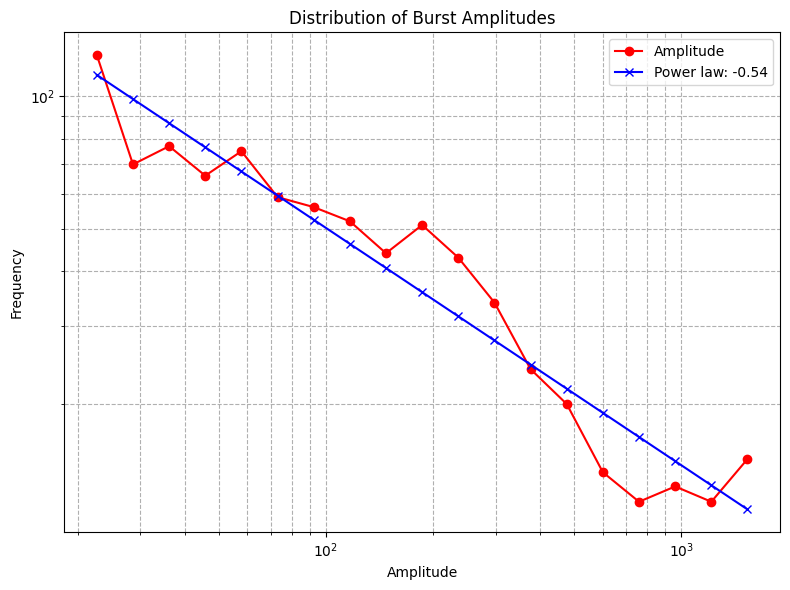

In [153]:
bins = np.logspace(np.log10(min(amplitudes)), np.log10(max(amplitudes)), 20)
hist, bin_edges = np.histogram(amplitudes, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

nonzero = hist > 0
x = bin_centers[nonzero]
y = hist[nonzero]

log_x = np.log10(x)
log_y = np.log10(y)
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
fit_y = 10**(slope * log_x + intercept)

plt.figure(figsize=(8, 6))
plt.loglog(x, y, '-ro', label='Amplitude')
plt.loglog(x, fit_y, '-bx', label=f'Power law: {slope:.2f}')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Distribution of Burst Amplitudes')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig(os.path.join(f'{data['newdir'].item()}', "ampdist"))
plt.show()


(910, 21)

In [69]:
widths = data['handlesA'].item()['width']
widths.shape

(0,)

In [24]:
areas = data['handlesA'].item()['area']
areas.shape

(940,)

In [25]:
rises = data['handlesA'].item()['rise']
rises.shape

(940,)

In [26]:
falls = data['handlesA'].item()['fall']
falls.shape

(940,)

In [27]:
skews = data['handlesA'].item()['skew']
skews.shape

(940,)

In [28]:
kurts = data['handlesA'].item()['kurt']
kurts.shape

(940,)

In [29]:
labels = data['handlesA'].item()['species']
labels.shape

(940,)

In [30]:
assert amplitudes.shape == widths.shape == areas.shape == rises.shape == falls.shape == skews.shape == kurts.shape == labels.shape
assert (labels == -1).sum() == 0

In [ ]:
df = pd.DataFrame({
    'Amplitude':amplitudes,
    'Width':widths,
    'Labels':labels
    #'Area':areas,
    'RiseTime':rises,
    #'FallTime':falls,
    #'Skewness':skews,
    #'Kurtosis':kurts,
})

In [32]:
(df['Labels']).shape

(940,)

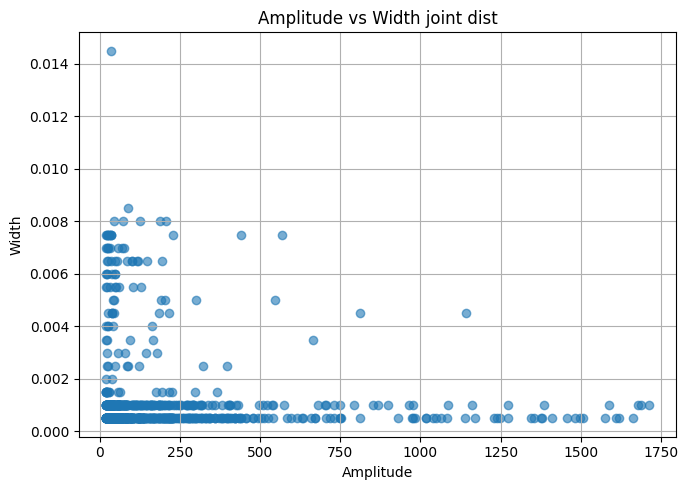

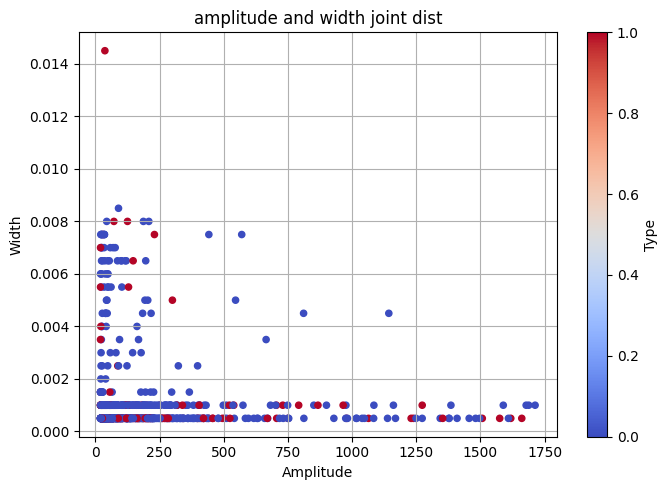

In [33]:
plt.figure(figsize=(7, 5))
plt.scatter(df['Amplitude'], df['Width'], alpha=0.6)
plt.xlabel('Amplitude')
plt.ylabel('Width')
plt.title('Amplitude vs Width joint dist')
plt.grid(True)
plt.tight_layout()
plt.show()

#scaler = StandardScaler()
#X = scaler.fit_transform(df[['Amplitude', 'Width']])
#y = df['Labels']
#df = pd.DataFrame(X, columns = ['Amplitude', 'Width'])
#df['Labels'] = y.values
plt.figure(figsize=(7, 5))
scatter = plt.scatter(df['Amplitude'], df['Width'], c=df['Labels'], cmap='coolwarm', s=20)
plt.xlabel('Amplitude')
plt.ylabel('Width')
plt.title(f'amplitude and width joint dist')
plt.grid(True)
plt.tight_layout()
plt.colorbar(scatter, label='Type')
plt.show()
import plotly.express as px
#df = df[df['Labels'] != -1]
fig = px.scatter(
    df,
    x='Amplitude',
    y='Width',
    color='Labels',
    color_continuous_scale='viridis',
    title='Amplitude and Width Joint Dist',
    labels={'Amplitude': 'Amplitude', 'Width': 'Width', 'Labels': 'Type'},
    width=700,
    height=500
)

fig.update_layout(
    title_x=0.5,
    margin=dict(l=40, r=40, t=60, b=40),
    plot_bgcolor='white',
)

fig.update_traces(marker=dict(size=6, line=dict(width=0)))

fig.show()


In [50]:
import pandas as pd
import plotly.express as px

filter = 1
df = pd.DataFrame({
    'Amplitude': areas[labels!=filter]/amplitudes[labels!=filter],
    'Width': rises[labels!=filter] / widths[labels!=filter],
    'RiseTime': widths[labels!=filter]/amplitudes[labels!=filter],
    'Labels': labels[labels!=filter]
})

fig = px.scatter_3d(
    df,
    x='Amplitude',
    y='Width',
    z='RiseTime',
    color='Labels',
    title='3D Burst Feature Distribution Colored by Species',
    labels={'Labels': 'Species'}
)

fig.update_layout(scene=dict(
    xaxis_title='Amplitude',
    yaxis_title='Width',
    zaxis_title='Rise Time'
))

fig.show()


filter = 0
df = pd.DataFrame({
    'Amplitude': areas[labels!=filter]/amplitudes[labels!=filter],
    'Width': rises[labels!=filter] / widths[labels!=filter],
    'RiseTime': widths[labels!=filter]/amplitudes[labels!=filter],
    'Labels': labels[labels!=filter]
})

fig = px.scatter_3d(
    df,
    x='Amplitude',
    y='Width',
    z='RiseTime',
    color='Labels',
    title='3D Burst Feature Distribution Colored by Species',
    labels={'Labels': 'Species'}
)

fig.update_layout(scene=dict(
    xaxis_title='Amplitude',
    yaxis_title='Width',
    zaxis_title='Rise Time'
))

fig.show()



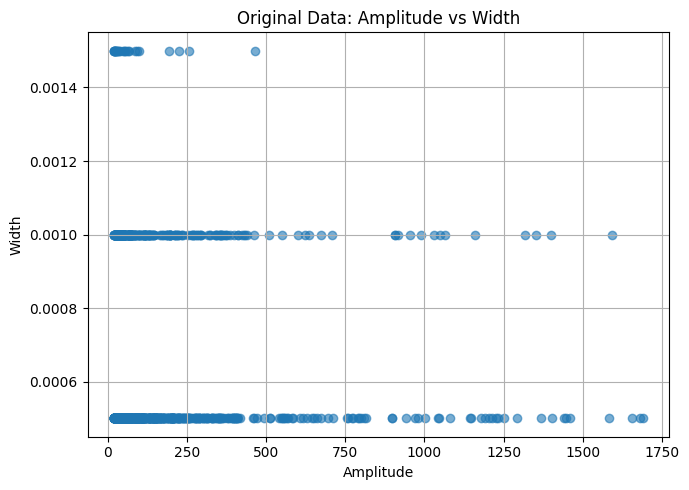

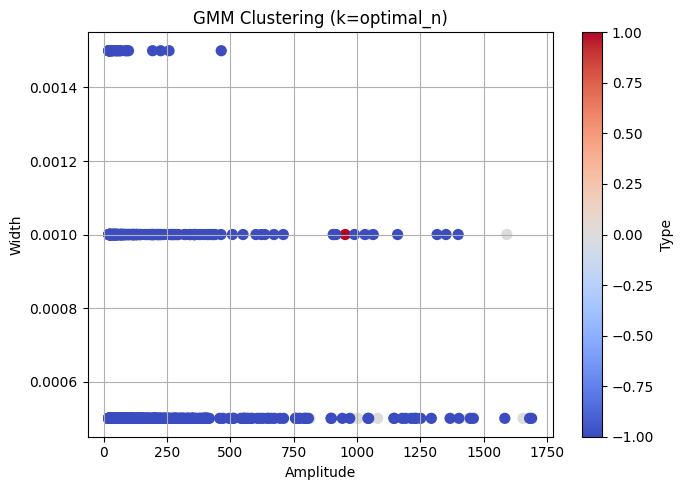

In [298]:
plt.figure(figsize=(7, 5))
plt.scatter(df['Amplitude'], df['Width'], alpha=0.6)
plt.xlabel('Amplitude')
plt.ylabel('Width')
plt.title('Original Data: Amplitude vs Width')
plt.grid(True)
plt.tight_layout()
plt.show()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Step 4: Find optimal number of clusters using silhouette score
# range_n = range(2, 10)
# silhouette_scores = []

# for n in range_n:
#     gmm = GaussianMixture(n_components=n, random_state=42)
#     labels = gmm.fit_predict(scaled_features)
#     score = silhouette_score(scaled_features, labels)
#     silhouette_scores.append(score)

# # Determine the optimal number of clusters
# optimal_n = range_n[np.argmax(silhouette_scores)]

# # Step 5: Fit GMM with optimal clusters
# gmm = GaussianMixture(n_components=optimal_n, random_state=42)
# df['Cluster'] = gmm.fit_predict(scaled_features)

# Step 6: Plot clustered data
plt.figure(figsize=(7, 5))
scatter = plt.scatter(df['Amplitude'], df['Width'], c=df['Labels'], cmap='coolwarm', s=50)
plt.xlabel('Amplitude')
plt.ylabel('Width')
plt.title(f'GMM Clustering (k={"""optimal_n"""})')
plt.grid(True)
plt.tight_layout()
plt.colorbar(scatter, label='Type')
plt.show()


In [299]:
df.corr()

,Amplitude,Width,Labels
Amplitude,1.000000,-0.017332,0.015180
Width,-0.017332,1.000000,-0.012304
Labels,0.015180,-0.012304,1.000000


Standardize Data

In [254]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

Gaussian Mixture Model

In [255]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score

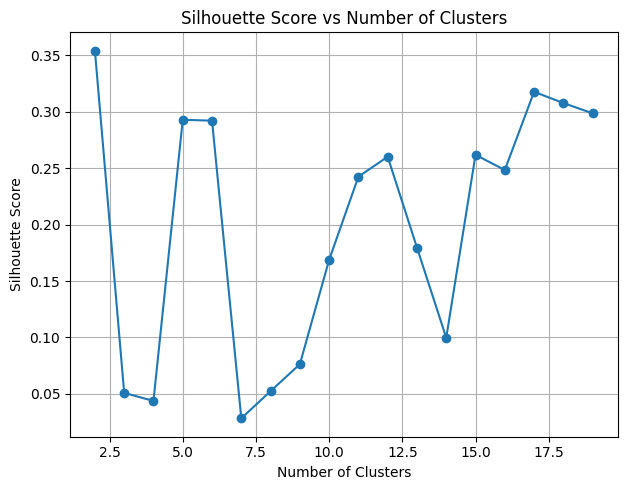

In [264]:
bic_scores = []
silhouette_scores = []
range_n = range(2, 20)
for n in range_n:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(scaled_features)
    #bic_scores.append(gmm.bic(scaled_features))
    labels = gmm.predict(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, labels))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)


plt.tight_layout()
plt.show()



In [257]:
optimal_n = range_n[np.argmin(bic_scores)]
gmm = GaussianMixture(n_components=optimal_n, random_state=42)
df['Cluster'] = gmm.fit_predict(scaled_features)

In [226]:
optimal_n

9

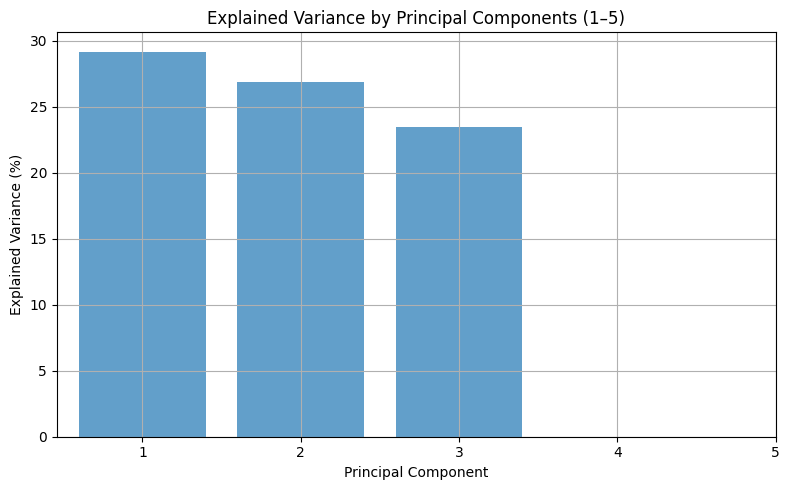

In [268]:
pca_3 = PCA(n_components=3)
pca_result_3 = pca_3.fit_transform(scaled_features)

# Explained variance bar plot for 1-5 components
explained_variance = pca_3.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.bar(range(1, 4), explained_variance * 100, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Components (1–5)')
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

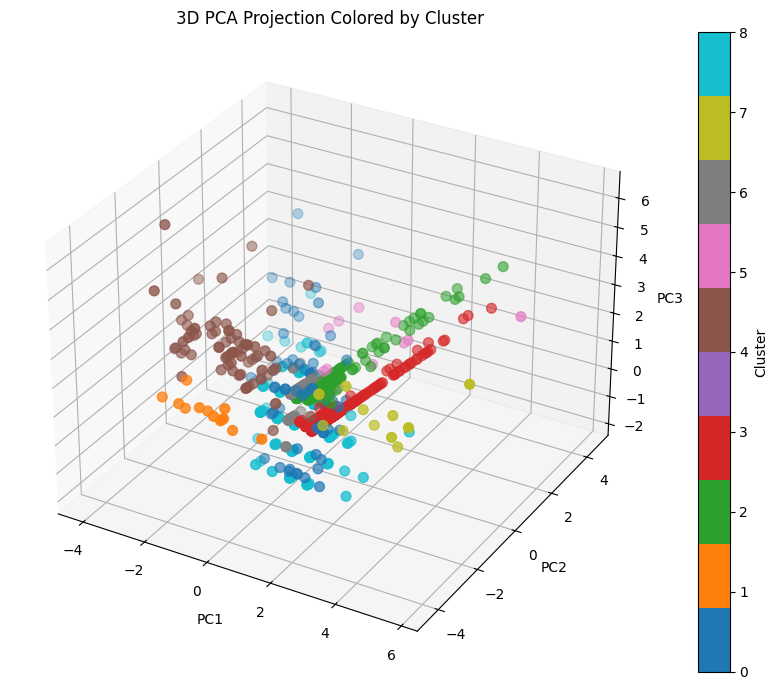

In [269]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3[:, 0], pca_result_3[:, 1], pca_result_3[:, 2],
                     c=df['Cluster'], cmap='tab10', s=50)
ax.set_title('3D PCA Projection Colored by Cluster')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

In [270]:
import plotly.express as px
import pandas as pd

# Assume pca_result_3 is a NumPy array of shape (n_samples, 3)
# and df['Cluster'] already contains the GMM cluster labels

pca_df = pd.DataFrame(pca_result_3, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = df['Cluster']

fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    color_continuous_scale='Viridis',
    title='Interactive 3D PCA Projection Colored by Cluster',
    labels={'Cluster': 'Cluster'},
    width=800,
    height=700
)

fig.update_traces(marker=dict(size=5))
fig.show()


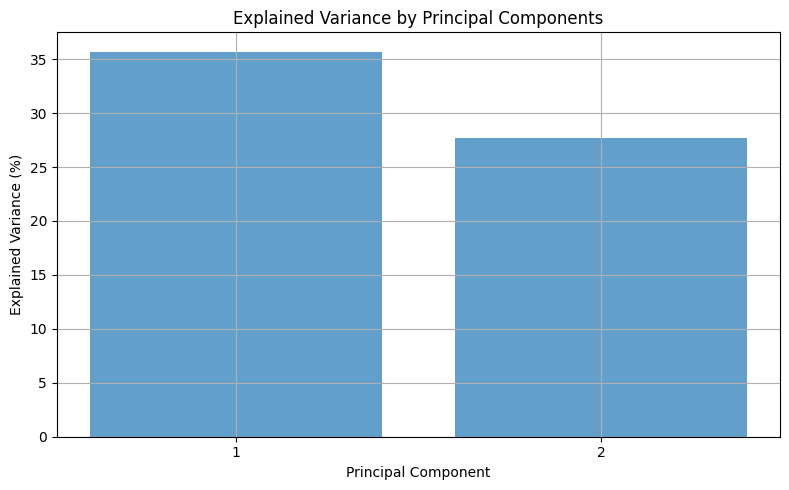

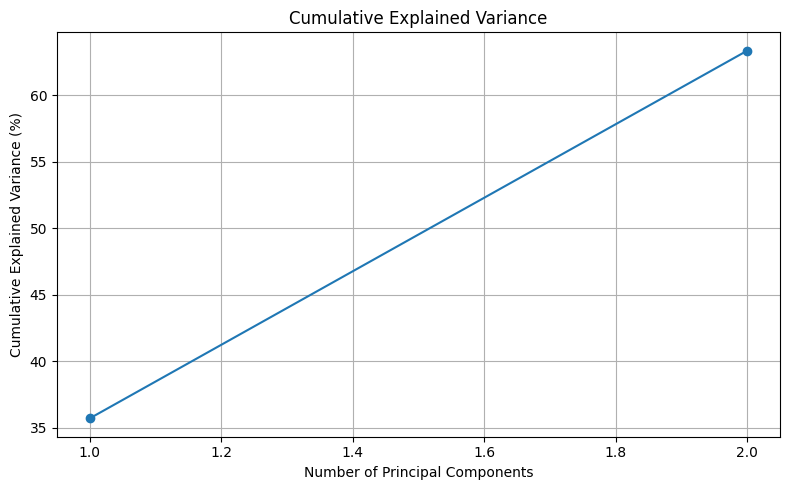

In [115]:
# Plot cumulative explained variance
# Plot explained variance
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()


cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()
